In [ ]:
import ipykernel
import pandas as pd
import numpy as np
import sklearn
import xgboost
import tensorflow as tf
import seaborn as sb
import matplotlib.pyplot as mp

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
import imblearn
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [175]:
import warnings
warnings.filterwarnings("ignore")

# #only the code that generates warnings, but this with block has to be placed in the cell where you dont want to print warnings.
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")

In [ ]:
# Provide the full path to the file or ensure the file is in the current working directory
data = pd.read_csv(r"d:/Data Science/Machine Learning & Deep Learning ANN (Regression & Classification)/Classification Practicals/Subscription_to_TermDeposit/bank-full.csv")

#target variable set to 1 or 0 instead of yes and no
data['y'] = data['y'].apply(lambda x: 1 if x=='yes' else 0)

#convert categorical into dummies
data = pd.get_dummies(data, drop_first=True, dtype='int')

In [265]:
#split the data into train, test

X = data.drop(columns='y')
y = data['y']

#train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [317]:
def plot_roc_auc_curve(model):
    y_probs = model.predict_proba(X_test)[:,1]

        
    #extract probabilities of class 1 only - focus is on positive classes
    y_probs = model.predict_proba(X_test)[:,1]    

    #roc_curve results in fpr, tpr values and threshold, let's save fpr, tpr only
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_probs)      

    #calculate auc 
    auc_value = round(auc(fpr,tpr),2)
    # print(auc_value)

    #plot roc, auc curve
    #define the size of the plot
    mp.figure(figsize=(5,3))

    #feed in values - fpr, tpr, auc as text format
    mp.plot(fpr, tpr, color='blue', label='ROC Curve')
    mp.plot([0,1], [0,1], color='gray', linestyle='--', label='AUC')
    mp.text(x=0.38, y=0.6, s=f'AUC={auc_value}', fontsize=10)

    #label the plot on x-axis and y-axis
    mp.title("ROC-AUC curve", fontsize=11)
    mp.xlabel('False Positive Rate (FPR)')
    mp.ylabel('True Positive Rate (TPR)')
    mp.legend(loc='lower right')
    mp.savefig("D:\Data Science\Machine Learning & Deep Learning ANN (Regression & Classification)\Classification Practicals\Subscription_to_TermDeposit\VSCode\plots\ROC-AUC curve the best model.jpg", dpi=300, bbox_inches='tight')
    mp.show()

Accuracy:0.89, Recall:0.21

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94     11966
           1       0.60      0.21      0.31      1598

    accuracy                           0.89     13564
   macro avg       0.75      0.60      0.63     13564
weighted avg       0.87      0.89      0.87     13564

Confusion matrix:
 [[11738   228]
 [ 1257   341]]


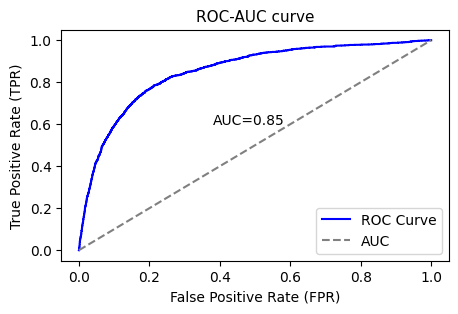

In [318]:
#Logistic Regression model with data imbalance 
logistic_model = LogisticRegression()

#fit on train data 
logistic_model.fit(X_train, y_train)

#make predictions on test data 
logistic_predictions = logistic_model.predict(X_test)

#Performance metrics
logistic_accuracy = round(accuracy_score(y_test, logistic_predictions),2)
logistic_recall = round(recall_score(y_test, logistic_predictions),2)

print(f'Accuracy:{logistic_accuracy}, Recall:{logistic_recall}')
print()
print("Classification report:\n", classification_report(y_test, logistic_predictions))
print("Confusion matrix:\n", confusion_matrix(y_test, logistic_predictions))

#ROC-AUC
plot_roc_auc_curve(logistic_model)

Accuracy:0.87, Recall:0.55

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93     11966
           1       0.46      0.55      0.50      1598

    accuracy                           0.87     13564
   macro avg       0.70      0.73      0.71     13564
weighted avg       0.88      0.87      0.87     13564

Confusion matrix:
 [[10930  1036]
 [  726   872]]


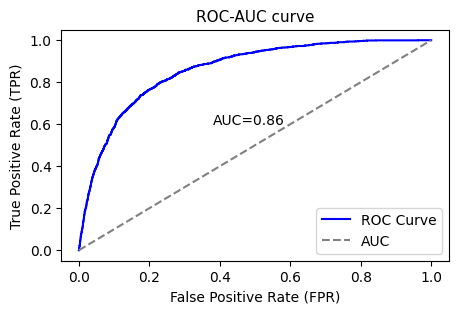

In [319]:
# Logistic regression model after data balancing
# Apply SMOTE for oversampling the minority class

smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train on the resampled dataset
logistic_model_resampled = logistic_model.fit(X_resampled, y_resampled)

#make predictions on test data 
logistic_resampled_predictions = logistic_model_resampled.predict(X_test)

#Performance metrics
logistic_resampled_accuracy = round(accuracy_score(y_test, logistic_resampled_predictions),2)
logistic_resampled_recall = round(recall_score(y_test, logistic_resampled_predictions),2)

print(f'Accuracy:{logistic_resampled_accuracy}, Recall:{logistic_resampled_recall}')
print()
print("Classification report:\n", classification_report(y_test, logistic_resampled_predictions))
print("Confusion matrix:\n", confusion_matrix(y_test, logistic_resampled_predictions))

#ROC-AUC
plot_roc_auc_curve(logistic_model_resampled)

Accuracy:0.91, Recall:0.41

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     11966
           1       0.66      0.41      0.51      1598

    accuracy                           0.91     13564
   macro avg       0.79      0.69      0.73     13564
weighted avg       0.89      0.91      0.90     13564

Confusion matrix:
 [[11633   333]
 [  941   657]]


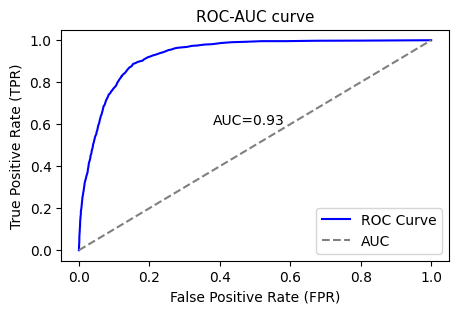

In [325]:
#Random Forest model before data balancing
random_forest_model = RandomForestClassifier(n_estimators=250)

#fit on train data 
random_forest_model.fit(X_train, y_train)

#make predictions on test data 
random_forest_predictions = random_forest_model.predict(X_test)

#Performance metrics
random_forest_accuracy = round(accuracy_score(y_test, random_forest_predictions),2)
random_forest_recall = round(recall_score(y_test, random_forest_predictions),2)

print(f'Accuracy:{random_forest_accuracy}, Recall:{random_forest_recall}')
print()

print("Classification report:\n", classification_report(y_test, random_forest_predictions))
print("Confusion matrix:\n", confusion_matrix(y_test, random_forest_predictions))

#ROC-AUC
plot_roc_auc_curve(random_forest_model)

Accuracy:0.91, Recall:0.48
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     11966
           1       0.65      0.48      0.55      1598

    accuracy                           0.91     13564
   macro avg       0.79      0.72      0.75     13564
weighted avg       0.90      0.91      0.90     13564

Confusion matrix:
 [[11548   418]
 [  827   771]]


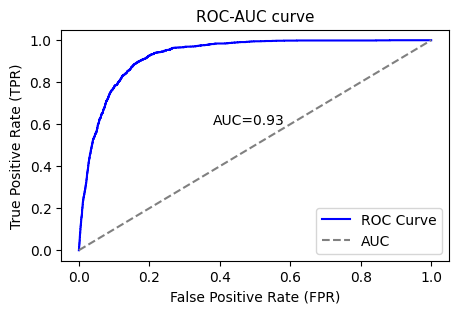

In [284]:
#Gradient Boosting model 
gradient_boost_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.4)

#fit on train data 
gradient_boost_model.fit(X_train, y_train)

#make predictions on test data 
gradient_boost_predictions = gradient_boost_model.predict(X_test)

#Performance metrics
gradient_boost_accuracy = round(accuracy_score(y_test, gradient_boost_predictions),2)
gradient_boost_recall = round(recall_score(y_test, gradient_boost_predictions),2)

print(f'Accuracy:{gradient_boost_accuracy}, Recall:{gradient_boost_recall}')

print("Classification report:\n", classification_report(y_test, gradient_boost_predictions))
print("Confusion matrix:\n", confusion_matrix(y_test, gradient_boost_predictions))

#ROC-AUC
plot_roc_auc_curve(gradient_boost_model)

Accuracy:0.91, Recall:0.5
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     11966
           1       0.63      0.50      0.56      1598

    accuracy                           0.91     13564
   macro avg       0.78      0.73      0.75     13564
weighted avg       0.90      0.91      0.90     13564

Confusion matrix:
 [[11495   471]
 [  793   805]]


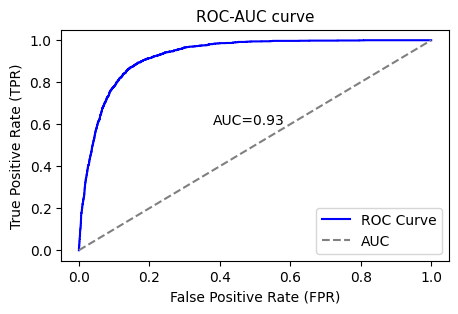

In [322]:
#XG Boosting model 
xgb_model = XGBClassifier(n_estimators=150)

#fit on train data 
xgb_model.fit(X_train, y_train)

#make predictions on test data 
xgb_predictions = xgb_model.predict(X_test)

#Performance metrics
xgb_accuracy = round(accuracy_score(y_test, xgb_predictions),2)
xgb_recall = round(recall_score(y_test, xgb_predictions),2)

print(f'Accuracy:{xgb_accuracy}, Recall:{xgb_recall}')

print("Classification report:\n", classification_report(y_test, xgb_predictions))
print("Confusion matrix:\n", confusion_matrix(y_test, xgb_predictions))

#ROC-AUC curve
plot_roc_auc_curve(xgb_model)

In [184]:
# Recall of 0.12 means model is able to identify 12% of the positive classes only
#precision of 0.53 means 53% of the times model is precise with positive classes

#data imbalance is the cause - let's over sample the minority class

In [185]:
# Loss Function: 
# 'binary_crossentropy' for binary classification, 
# 'categorical_crossentropy' for Multi-class classification (one-hot labels), 
# 'sparse_categorical_crossentropy'	Multi-class (integer labels, not one-hot)

In [273]:
#Neural network model
neural_network_model = Sequential()
neural_network_model.add(Input(shape=(42,)))    #input layer
neural_network_model.add(Dense(units=100, activation='sigmoid'))    #hidden layer
neural_network_model.add(Dense(units=1, activation='sigmoid')) #output layer units=1 because target has 2 classes, sigmoid predicts either 0 or 1 for every data point   

#compile the model with optimizer 
neural_network_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

#fit the model on training data
callback = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='max', restore_best_weights=True)

neural_network_model.fit(x=X_train, 
          y=y_train, 
          batch_size=32, 
          epochs=50, 
          validation_data=(X_test, y_test), 
          verbose=1, 
          callbacks=[callback])

#make predictions
neural_network_probabilities = neural_network_model.predict(X_test)
neural_network_predictions = (neural_network_probabilities>0.5).astype(int)   #we dont explcitly say if>0.5 make it 1. 

#Performance metrics
neural_network_accuracy = accuracy_score(y_test, neural_network_predictions)
neural_network_recall = recall_score(y_test, neural_network_predictions)

print(f'Accuracy:{neural_network_accuracy}, Recall:{neural_network_recall}')

print("Classification report:\n", classification_report(y_test, neural_network_predictions))
print("Confusion matrix:\n", confusion_matrix(y_test, neural_network_predictions))

Epoch 1/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8081 - loss: 0.4214 - val_accuracy: 0.8828 - val_loss: 0.2839
Epoch 2/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8874 - loss: 0.2826 - val_accuracy: 0.8829 - val_loss: 0.2815
Epoch 3/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8857 - loss: 0.2817 - val_accuracy: 0.8848 - val_loss: 0.2789
Epoch 4/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8885 - loss: 0.2720 - val_accuracy: 0.8884 - val_loss: 0.2745
Epoch 5/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8865 - loss: 0.2768 - val_accuracy: 0.8846 - val_loss: 0.2709
Epoch 6/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8862 - loss: 0.2714 - val_accuracy: 0.8861 - val_loss: 0.2697
Epoch 7/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8917 - loss: 0.2625 - val_accuracy: 0.8837 - val_loss: 0.2687
Epoch 8/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8876 - loss: 0.2613 - val_accuracy: 0.

In [ ]:
# Validation accuracy> Training accuracy -> better model , not overfitting. 

# validation_loss<training_loss -> this often means the model is generalizing well so far.

# If this trend continues (val accuracy improves, loss drops), your model is learning properly. 